In [1]:
import sys, os
sys.path.append(os.path.abspath(os.path.join('..')))

In [2]:
import numpy as np 
import scipy
from operators.setup_ROM import SimulationSetupROM
from operators.poisson_solver import gmres_solver, fft_solver
from operators.FOM import psi_ln_aw, charge_density
from operators.FOM import total_mass, total_momentum, total_energy_k

In [3]:
import matplotlib.pyplot as plt
import matplotlib
font = {'family' : 'serif',
        'size'   : 14}

matplotlib.rc('font', **font)
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14) 

# Linear Landau Damping 

In [4]:
setup = SimulationSetupROM(Nx=150,
                           Nv=20,
                           epsilon=1e-2,
                           alpha_e=0.75,
                           alpha_i=np.sqrt(2 / 1836),
                           u_e=0,
                           u_i=0,
                           L=2 * np.pi,
                           dt=1e-2,
                           T0=0,
                           T=80,
                           nu=10,
                           Nr=50,
                           M=3,
                           problem_dir="linear_landau",
                           Ur_e=np.load("../data/ROM/linear_landau/basis_3.npy"),
                           construct=False,
                           load=False,
                           ions=False)

In [5]:
# ions (unperturbed)
C0_ions = np.ones(setup.Nx) / setup.alpha_i

In [6]:
# velocity grid for plotting purposes
v = np.linspace(-3, 3, int(1e4))
# spatial grid 
x = np.linspace(0, setup.L, setup.Nx + 1)

# ROM simulation data

In [7]:
# load the simulation results
sol_u_reduced = np.load("../data/ROM/linear_landau/sample_" + str(setup.alpha_e) + "/M" + str(setup.M) + "/sol_midpoint_u_" + str(setup.Nr) + "_nu_" + str(setup.nu) + "_" + str(setup.T0) + "_" + str(setup.T) + ".npy")
sol_midpoint_t = np.load("../data/ROM/linear_landau/sample_" + str(setup.alpha_e) + "/M" + str(setup.M) + "/sol_midpoint_t_" + str(setup.Nr) + "_nu_" + str(setup.nu) + "_" + str(setup.T0) + "_" + str(setup.T) + ".npy")

In [8]:
sol_u_ROM = np.zeros((setup.Nx*setup.Nv, len(sol_midpoint_t)))
sol_u_ROM[:setup.NF, :] = sol_u_reduced[:setup.NF, :]
sol_u_ROM[setup.NF:, :] = setup.Ur_e @ sol_u_reduced[setup.NF:, :]

In [9]:
# initialize the electric potential
E_midpoint = np.zeros((setup.Nx + 1, len(sol_midpoint_t)))

In [10]:
# initialize the states for implicit midpoint (symplectic)
state_e_midpoint = np.zeros((setup.Nv,  setup.Nx + 1, len(sol_midpoint_t)))
state_i_midpoint = np.zeros((setup.Nv,  setup.Nx + 1, len(sol_midpoint_t)))

for ii in np.arange(0, len(sol_midpoint_t), 1):
    print("time = ", sol_midpoint_t[ii])
    for n in range(setup.Nv):
        # unwind the flattening to solve the Vlasov-Poisson system
        # electrons
        state_e_midpoint[n, :-1, ii]  = sol_u_ROM[n*setup.Nx: (n+1)*setup.Nx, ii]
        state_e_midpoint[n, -1, ii] = state_e_midpoint[n, 0, ii]

    # immobile ions
    state_i_midpoint[0, :-1, ii] = C0_ions
    state_i_midpoint[0, -1, ii] = state_i_midpoint[0, 0, ii]

    # solve Poisson's equation to obtain an electric field
    rho = charge_density(alpha_e=setup.alpha_e, alpha_i=setup.alpha_i,
                                        q_e=setup.q_e, q_i=setup.q_i,
                                        C0_e=state_e_midpoint[0, :setup.Nx, ii],
                                        C0_i=C0_ions)
    
    E_midpoint[:-1, ii] = gmres_solver(rhs=rho, D=setup.D)
    E_midpoint[-1, ii] = E_midpoint[0, ii]

time =  0.0
time =  0.01
time =  0.02
time =  0.03
time =  0.04
time =  0.05
time =  0.06
time =  0.07
time =  0.08
time =  0.09
time =  0.1
time =  0.11
time =  0.12
time =  0.13
time =  0.14
time =  0.15
time =  0.16
time =  0.17
time =  0.18
time =  0.19
time =  0.2
time =  0.21
time =  0.22
time =  0.23
time =  0.24
time =  0.25
time =  0.26
time =  0.27
time =  0.28
time =  0.29
time =  0.3
time =  0.31
time =  0.32
time =  0.33
time =  0.34
time =  0.35000000000000003
time =  0.36
time =  0.37
time =  0.38
time =  0.39
time =  0.4
time =  0.41000000000000003
time =  0.42
time =  0.43
time =  0.44
time =  0.45
time =  0.46
time =  0.47000000000000003
time =  0.48
time =  0.49
time =  0.5
time =  0.51
time =  0.52
time =  0.53
time =  0.54
time =  0.55
time =  0.56
time =  0.5700000000000001
time =  0.58
time =  0.59
time =  0.6
time =  0.61
time =  0.62
time =  0.63
time =  0.64
time =  0.65
time =  0.66
time =  0.67
time =  0.68
time =  0.6900000000000001
time =  0.70000000000000

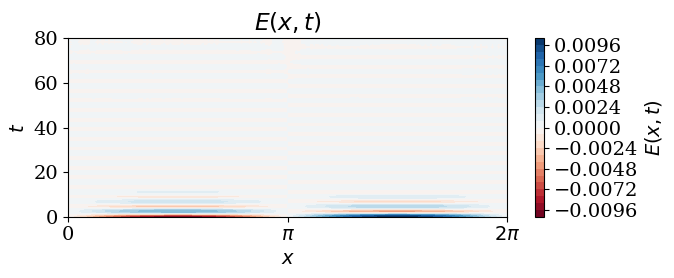

In [11]:
# plot the electric field
fig, ax = plt.subplots(figsize=(7, 3))
pos = ax.contourf(x, sol_midpoint_t, E_midpoint.T, cmap="RdBu", levels=30)
cbar = fig.colorbar(pos)
cbar.ax.set_ylabel("$E(x, t)$", rotation=90)
ax.set_title("$E(x, t)$")
ax.set_xlabel("$x$")
_ = ax.set_xticks([0, np.pi, 2*np.pi])
_ = ax.set_xticklabels([r"0", r"$\pi$", r"$2\pi$"])
_ = ax.set_ylabel("$t$")
plt.tight_layout()

#plt.savefig("../figs/ROM/linear_landau/electric_field_FOM" + str(setup.Nv)+ ".png", dpi=600)

In [12]:
# compute the electric field k=1 mode amplitude using fft
E1_midpoint = np.zeros(len(sol_midpoint_t))

for ii in range(len(sol_midpoint_t)):
    E1_midpoint[ii] = np.abs(scipy.fft.fft(E_midpoint[:, ii]))[1]

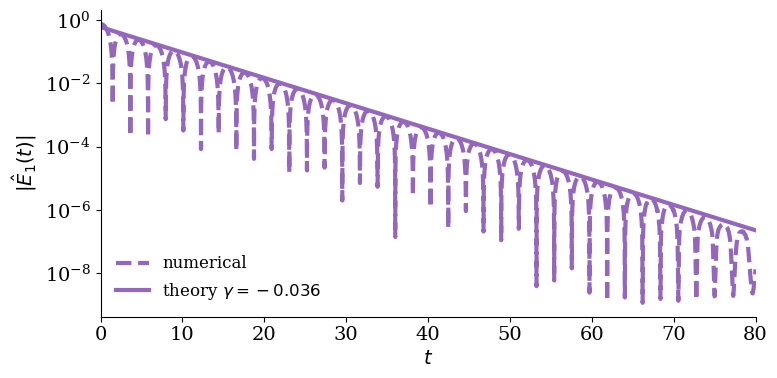

In [13]:
# plot the electric field damping rate
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(sol_midpoint_t, E1_midpoint, "--", c="tab:purple",linewidth=3, label="numerical") 
ax.plot(sol_midpoint_t, 0.6*np.exp(-0.1848*sol_midpoint_t), linewidth=3, color="tab:purple", label=r"theory $\gamma = -0.036$") 

ax.set_yscale("log")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel("$|\hat{E}_{1}(t)|$")
ax.set_xlabel("$ t$")
ax.set_xlim(0, setup.T)
legend = ax.legend(ncols=1, fancybox=False, shadow=False, fontsize=12, loc='lower left')
legend.get_frame().set_alpha(0)
plt.tight_layout()
#plt.savefig("../figs/FOM/linear_landau/electric_field_damping_rate_" + str(setup.Nv) + ".png", dpi=600)

In [18]:
# save the electric field
np.save("../data/ROM/linear_landau/sample_" + str(setup.alpha_e) + "/M" + str(setup.M) + "/sol_midpoint_E_" + str(setup.Nr) + "_alpha_" + str(setup.alpha_e) + ".npy", E_midpoint)
np.save("../data/ROM/linear_landau/sample_" + str(setup.alpha_e) + "/M" + str(setup.M) + "/sol_midpoint_E1_" + str(setup.Nr) + "_alpha_" + str(setup.alpha_e) + ".npy", E1_midpoint)

In [19]:
# save the electric field
E_coeff_FOM = np.load("../data/FOM/linear_landau/sample_" + str(setup.alpha_e) + "/sol_midpoint_E1_" + str(setup.Nv) + "_alpha_" + str(setup.alpha_e) + ".npy")
E_coeff_ROM25 = np.load("../data/ROM/linear_landau/sample_" + str(setup.alpha_e) + "/M" + str(setup.M) + "/sol_midpoint_E1_25_alpha_" + str(setup.alpha_e) + ".npy")
E_coeff_ROM50 = np.load("../data/ROM/linear_landau/sample_" + str(setup.alpha_e) + "/M" + str(setup.M) + "/sol_midpoint_E1_50_alpha_" + str(setup.alpha_e) + ".npy")
#E_coeff_ROM50 = np.load("../data/ROM/linear_landau/sample_" + str(setup.alpha_e) + "/M" + str(setup.M) + "/sol_midpoint_E1_15_alpha_" + str(setup.alpha_e) + ".npy")

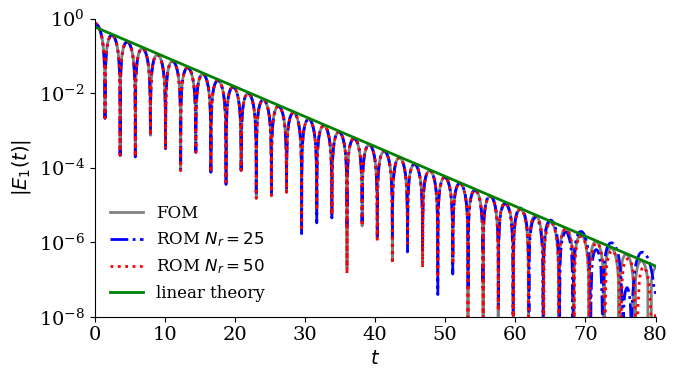

In [26]:
# plot the electric field damping rate
fig, ax = plt.subplots(figsize=(7, 4))
ax.plot(sol_midpoint_t, np.abs(E_coeff_FOM) ,c="grey", linewidth=2, label=r"FOM")
ax.plot(sol_midpoint_t, np.abs(E_coeff_ROM25), "-.", c="blue",  linewidth=2, label=r"ROM $N_{r}=25$")
ax.plot(sol_midpoint_t, np.abs(E_coeff_ROM50), ":", c="red", linewidth=2, label="ROM $N_{r}=50$")
ax.plot(sol_midpoint_t, 0.6*np.exp(-0.1848*sol_midpoint_t), linewidth=2, color="green", label=r"linear theory") 

ax.set_yscale("log")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel("$|E_{1}(t)|$")
ax.set_xlabel("$ t$")
ax.set_xlim(0, setup.T)
ax.set_yticks([1e0, 1e-2, 1e-4, 1e-6, 1e-8])
ax.set_ylim(1e-8, 1)
legend = ax.legend(ncols=1, fancybox=False, shadow=False, fontsize=12, loc='lower left')
legend.get_frame().set_alpha(0)
plt.tight_layout()
plt.savefig("../figs/ROM/linear_landau/electric_field_damping_rate_ROM_" +str(setup.alpha_e) + "_M" + str(setup.M) + ".png", bbox_inches='tight', dpi=300)

In [17]:
RUNTIME100 = np.load("../data/ROM/linear_landau/sample_" + str(setup.alpha_e) + "/M" + str(setup.M) + "/sol_midpoint_u_100_nu_" + str(setup.nu) + "_runtime_" + str(setup.T0) + "_" + str(setup.T) + ".npy")[0]
RUNTIME50 = np.load("../data/ROM/linear_landau/sample_" + str(setup.alpha_e) + "/M" + str(setup.M) + "/sol_midpoint_u_50_nu_" + str(setup.nu) + "_runtime_" + str(setup.T0) + "_" + str(setup.T) + ".npy")[0]
RUNTIME25 = np.load("../data/ROM/linear_landau/sample_" + str(setup.alpha_e) + "/M" + str(setup.M) + "/sol_midpoint_u_25_nu_" + str(setup.nu) + "_runtime_" + str(setup.T0) + "_" + str(setup.T) + ".npy")[0]

FileNotFoundError: [Errno 2] No such file or directory: '../data/ROM/linear_landau/sample_0.75/M3/sol_midpoint_u_100_nu_10_runtime_0_80.npy'

In [ ]:
ERR25 = epsilon_electric(E_ROM=E_coeff_ROM25, E_FOM=E_coeff_FOM, Nx=setup.Nx, avg_time=True).real
ERR50 = epsilon_electric(E_ROM=E_coeff_ROM50, E_FOM=E_coeff_FOM, Nx=setup.Nx, avg_time=True).real
ERR100 = epsilon_electric(E_ROM=E_coeff_ROM100, E_FOM=E_coeff_FOM, Nx=setup.Nx, avg_time=True).real

In [ ]:
print(ERR25)
print(ERR50)
print(ERR100)

In [ ]:
EFF25 = 1/(RUNTIME25*ERR25)
EFF50 = 1/(RUNTIME50*ERR50)
EFF100 = 1/(RUNTIME100*ERR100)

In [ ]:



np.save("../data/ROM/linear_landau/sample_" + str(setup.alpha_e) + "/M" + str(setup.M) + "/efficacy_results_M" + str(setup.M) + ".npy", np.array([EFF25, EFF50, EFF100]))
np.save("../data/ROM/linear_landau/sample_" + str(setup.alpha_e) + "/M" + str(setup.M) + "/runtime_results_M" + str(setup.M) + ".npy", np.array([RUNTIME25, RUNTIME50, RUNTIME100]))

In [ ]:
EFF3 = np.load("../data/ROM/linear_landau/sample_" + str(setup.alpha_e) + "/M3/efficacy_results_M3.npy")
EFF4 = np.load("../data/ROM/linear_landau/sample_" + str(setup.alpha_e) + "/M4/efficacy_results_M4.npy")
EFF5 = np.load("../data/ROM/linear_landau/sample_" + str(setup.alpha_e) + "/M5/efficacy_results_M5.npy")
RUN3 = np.load("../data/ROM/linear_landau/sample_" + str(setup.alpha_e) + "/M3/runtime_results_M3.npy")
RUN4 = np.load("../data/ROM/linear_landau/sample_" + str(setup.alpha_e) + "/M4/runtime_results_M4.npy")
RUN5 = np.load("../data/ROM/linear_landau/sample_" + str(setup.alpha_e) + "/M5/runtime_results_M5.npy")

In [ ]:
FOM_RUNTIME = np.load("../data/FOM/linear_landau/sample_" + str(setup.alpha_e) + "/sol_FOM_u_100_alpha_0.9_runtime_0_30.npy")

In [ ]:
# plot the electric field damping rate
fig, ax = plt.subplots(figsize=(6, 5.5))
ax.scatter(RUN3, EFF3, c="blue", marker="x", s=50, label="$M=3$")
ax.scatter(RUN4, EFF4, c="red", marker="o", s=50, label="$M=4$")
ax.scatter(RUN5, EFF5, c="green", marker=">", s=50, label="$M=5$")
#ax.axvline(FOM_RUNTIME[1], c="k", ls="--", label="FOM CPU runtime")
ax.set_xlabel("CPU runtime [seconds]")
ax.set_yscale("log")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel("efficacy")
legend = ax.legend(ncols=1, fancybox=False, shadow=False, fontsize=12, loc="upper left")
legend.get_frame().set_alpha(0)
plt.tight_layout()
plt.savefig("../figs/ROM/linear_landau/weak_landau_efficacy_cpu.png", dpi=600)

In [ ]:
# plot the electric field damping rate
fig, ax = plt.subplots(figsize=(6, 5.5))
ax.scatter((2*setup.Nx+1)*3 + np.array([20, 40, 60]), EFF3, c="blue", marker="x", s=50, label="$M=3$")
ax.scatter((2*setup.Nx+1)*4 + np.array([20, 40, 60]), EFF4, c="red", marker="o", s=50, label="$M=4$")
ax.scatter((2*setup.Nx+1)*5 + np.array([20, 40, 60]), EFF5, c="green", marker=">", s=50, label="$M=5$")

p = np.polyfit((2*setup.Nx+1)*3 + np.array([20, 40, 60]), np.log(EFF3), deg=1)
a = np.exp(p[1])
b = p[0]
x_fitted = (2*setup.Nx+1)*3 + np.linspace(20, 60, 100)
y_fitted = a * np.exp(b * x_fitted)
plt.plot(x_fitted, y_fitted, alpha=0.6, color="blue", linewidth=3)


p = np.polyfit((2*setup.Nx+1)*4 + np.array([20, 40, 60]), np.log(EFF4), deg=1)
a = np.exp(p[1])
b = p[0]
x_fitted = (2*setup.Nx+1)*4 + np.linspace(20, 60, 100) 
y_fitted = a * np.exp(b * x_fitted)
plt.plot(x_fitted, y_fitted, alpha=0.6, color="red", linewidth=3)


p = np.polyfit((2*setup.Nx+1)*5 + np.array([20, 40, 60]), np.log(EFF5), deg=1)
a = np.exp(p[1])
b = p[0]
x_fitted = (2*setup.Nx+1)*5 + np.linspace(20, 60, 100)
y_fitted = a * np.exp(b * x_fitted)
plt.plot(x_fitted, y_fitted, alpha=0.6, color="green", linewidth=3)

ax.set_xlabel("total number of dofs $N_{x, t}M + N_{r}$")
ax.set_yscale("log")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel("efficacy")
legend = ax.legend(ncols=1, fancybox=False, shadow=False, fontsize=12, loc="lower right")
legend.get_frame().set_alpha(0)
plt.tight_layout()
plt.savefig("../figs/ROM/linear_landau/weak_landau_efficacy.png", dpi=600)

# conservation laws: mass, momentum, and energy

### mass conservation

In [16]:
# compute mass at each timestamp
mass_midpoint = np.zeros(len(sol_midpoint_t))

for ii in range(0, len(sol_midpoint_t)):
    mass_midpoint[ii] = total_mass(state=state_e_midpoint[:, :-1, ii], alpha_s=setup.alpha_e, dx=setup.dx)\
                        +total_mass(state=state_i_midpoint[:, :-1, ii], alpha_s=setup.alpha_i, dx=setup.dx)

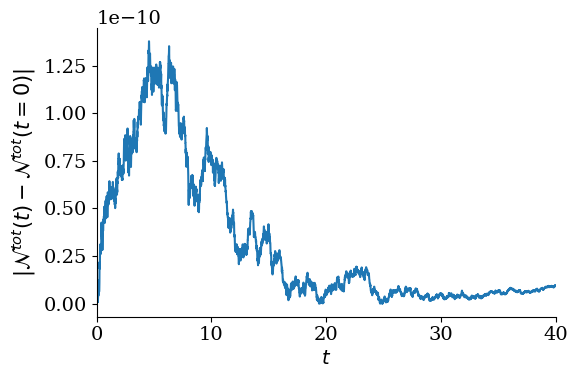

In [17]:
# plot mass conservation
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(sol_midpoint_t, np.abs(mass_midpoint - mass_midpoint[0]), "-")
#ax.set_yscale("log")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel(r"$|\mathcal{N}^{tot}(t) - \mathcal{N}^{tot}(t=0)|$", fontsize=15)
ax.set_xlabel("$t$")
ax.set_xlim(0, setup.T)
plt.tight_layout()

### momentum conservation

In [18]:
# compute momentum at each timestamp
momentum_midpoint = np.zeros(len(sol_midpoint_t))

for ii in range(0, len(sol_midpoint_t)):
    momentum_midpoint[ii] = total_momentum(state=state_e_midpoint[:, :, ii], alpha_s=setup.alpha_e, dx=setup.dx,
                                           m_s=setup.m_e, u_s=setup.u_e)\
                            +total_momentum(state=state_i_midpoint[:, :, ii], alpha_s=setup.alpha_i, dx=setup.dx,
                                           m_s=setup.m_i, u_s=setup.u_i)

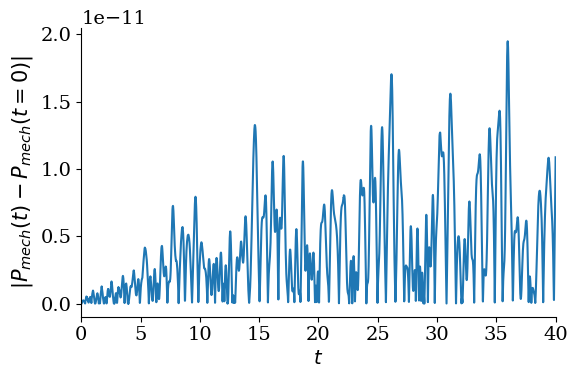

In [19]:
# plot momentum conservation
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(sol_midpoint_t, np.abs(momentum_midpoint - momentum_midpoint[0]), "-")
#ax.set_yscale("log")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel(r"$|P_{mech}(t)-P_{mech}(t=0)|$", fontsize=15)
ax.set_xlabel("$t$")
ax.set_xlim(0, setup.T)
plt.tight_layout()

### energy conservation

In [20]:
# compute energy (kinetic + potential) at each timestamp
energy_k_midpoint = np.zeros(len(sol_midpoint_t))
energy_p_midpoint = np.zeros(len(sol_midpoint_t))

for ii in range(0, len(sol_midpoint_t)):
    energy_k_midpoint[ii] = total_energy_k(state=state_e_midpoint[:, :-1, ii], alpha_s=setup.alpha_e, dx=setup.dx, m_s=setup.m_e, u_s=setup.u_e)\
                           +total_energy_k(state=state_i_midpoint[:, :-1, ii], alpha_s=setup.alpha_i, dx=setup.dx, m_s=setup.m_i, u_s=setup.u_i)
    
    energy_p_midpoint[ii] = 0.5*setup.dx*np.sum((E_midpoint[:-1, ii])**2)

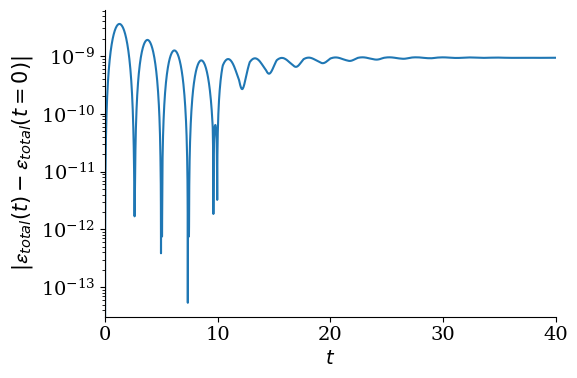

In [21]:
# plot energy conservation
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(sol_midpoint_t, np.abs(energy_p_midpoint + energy_k_midpoint -energy_p_midpoint[0]-energy_k_midpoint[0]), "-")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel(r"$|\mathcal{\epsilon}_{total}(t)-\mathcal{\epsilon}_{total}(t=0)|$", fontsize=15)
ax.set_xlabel("$ t$")
ax.set_xlim(0, setup.T)
ax.set_yscale("log")
plt.tight_layout()

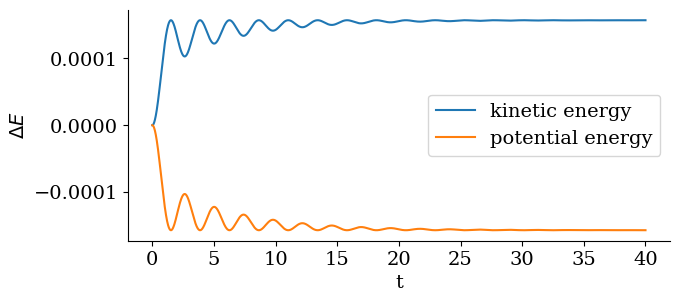

In [22]:
# plot the (kinetic + potential) energy exchange
fig, ax = plt.subplots(figsize=(7, 3))
plt.plot(sol_midpoint_t, energy_k_midpoint- energy_k_midpoint[0], label="kinetic energy")
plt.plot(sol_midpoint_t, energy_p_midpoint- energy_p_midpoint[0], label="potential energy")
plt.legend()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel("t")
_ = ax.set_ylabel(r"$\Delta E$")

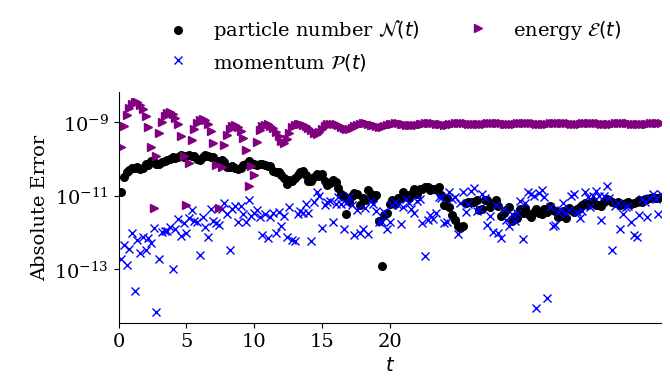

In [23]:
# plot the analytic and numerical conservation properties
fig, ax = plt.subplots(figsize=(7, 3))
ax.scatter(sol_midpoint_t[::20], np.abs(mass_midpoint-mass_midpoint[0])[::20], s=30, color="black", label=r"particle number $\mathcal{N}(t)$")
ax.plot(sol_midpoint_t[::20], np.abs(momentum_midpoint-momentum_midpoint[0])[::20], "x", color="blue", label=r"momentum $\mathcal{P}(t)$")
ax.plot(sol_midpoint_t[::20], np.abs(energy_p_midpoint + energy_k_midpoint -energy_p_midpoint[0]-energy_k_midpoint[0])[::20], ">", color="purple", label=r"energy $\mathcal{E}(t)$")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel(r"Absolute Error")
ax.set_xlabel("$t$")
ax.set_xlim(0, setup.T)
ax.set_yscale("log")
legend = ax.legend(ncols=2, fontsize=14, loc='upper center', bbox_to_anchor=(0.5, 1.4))
text = ax.text(-0.2,1.05, " ", transform=ax.transAxes)
legend.get_frame().set_alpha(0)
# plt.savefig("../figs/ROM/linear_landau/conservation_" + str(setup.Nv) + "_linear_landau__ROM.png", bbox_extra_artists=(legend,text), bbox_inches='tight', dpi=600)